# Product level Impact of 3.2 Beer in Minnesota

In [1]:
# packages used
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab as pl
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

### Load Store Data

In [2]:
#load the All stores in Minnesota
All_Stores_Minnesota = pd.read_csv('AllStoresMinnesota.csv')
All_Stores_Minnesota = All_Stores_Minnesota.rename(columns = {'WJXBFS1':'PROD_DEPLETION'})
All_Stores_Minnesota.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,102798460,CORONA EX 6PK BT,DINING,POLISHED CASUAL,ON,3.0
1,103923027,MODELO ESP 6PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,46.0
2,104034535,MODELO NEGRA 6PK BT,DINING,CASUAL DINING,ON,3.0
3,105647006,CORONA LT 6PK BT,DINING,CASUAL DINING,ON,8.0
4,101425811,MODELO NEGRA 12PK BT,LIQUOR,LIQUOR SUPER STORE,OFF,25.0


In [3]:
#clean data
All_Stores_Minnesota['RTL_STORE_CD'] = All_Stores_Minnesota['RTL_STORE_CD'].astype(str)
#remove NA Depletion 
All_Stores_Minnesota = All_Stores_Minnesota.loc[All_Stores_Minnesota['PROD_DEPLETION'].notnull(),:]

#remove Negative Depletion
All_Stores_Minnesota = All_Stores_Minnesota.loc[All_Stores_Minnesota['PROD_DEPLETION'] > 0.0,:] 
All_Stores_Minnesota.shape

(29546, 6)

In [4]:
len(All_Stores_Minnesota['RTL_STORE_CD'].unique())

6453

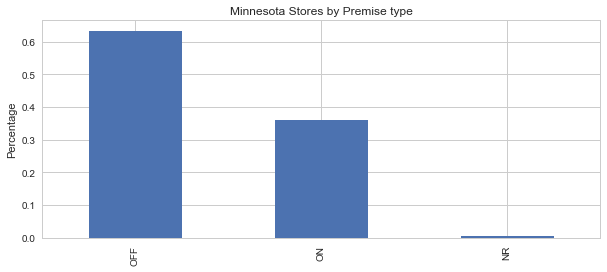

In [5]:
# Minnesota Stores by Premise type
premise_type = All_Stores_Minnesota.loc[:,'RTL_PREMISE_TYPE_CD']
premise_type = premise_type.value_counts()/len(premise_type)
ax = premise_type.plot.bar(figsize=(10,4), title = 'Minnesota Stores by Premise type')
ax.set_ylabel("Percentage");

### Load Product Data for On-Premise

In [6]:
LowPoint = pd.read_csv('MinnesotaLowPointProducts.csv')
LowPointOn = LowPoint.loc[LowPoint['RTL_PREMISE_TYPE_CD'] == 'ON', :].reset_index(drop = True)
Top5LowPointOn = LowPointOn.head(15)['ITEM_MASTER_SKU_DSC']
Top5LowPointOn

0            CORONA LT 6PK BT
1     CORONA LIGHT 1/2 BL KEG
2             VICTORIA 6PK BT
3           CORONA LT 12PK BT
4            VICTORIA 12PK BT
5       CORONA EX 3.2 12PK BT
6        CORONA EX 3.2 6PK BT
7     MODELO ESP 3.2 12PK CAN
8           CORONA LT 24PK BT
9           VICTORIA 12PK CAN
10         CORONA LT 12PK CAN
11      MODELO ESP 3.2 6PK BT
12    MODELO CHELADA 24OZ CAN
13    MODELO ESP 3.2 24OZ CAN
14    CORONA LIGHT 1/4 BL KEG
Name: ITEM_MASTER_SKU_DSC, dtype: object

In [7]:
#select top 5 products that are comparable:
Top5LowPointOn = Top5LowPointOn[[5,6,7,11,13]]
#put the products and their pairs into datafame
Top5_LowPoint_On_Pairs_DF = pd.DataFrame(Top5LowPointOn).reset_index(drop=True)
Top5_LowPoint_On_Pairs_DF['PAIRS'] = ['CORONA EX 12PK BT', 'CORONA EX 6PK BT', 'MODELO ESP 12PK CAN', 'MODELO ESP 6PK BT', 'MODELO ESP 24OZ CAN']
Top5_LowPoint_On_Pairs_DF

,ITEM_MASTER_SKU_DSC,PAIRS
0,CORONA EX 3.2 12PK BT,CORONA EX 12PK BT
1,CORONA EX 3.2 6PK BT,CORONA EX 6PK BT
2,MODELO ESP 3.2 12PK CAN,MODELO ESP 12PK CAN
3,MODELO ESP 3.2 6PK BT,MODELO ESP 6PK BT
4,MODELO ESP 3.2 24OZ CAN,MODELO ESP 24OZ CAN


In [8]:
BeerList_On = list(Top5_LowPoint_On_Pairs_DF['ITEM_MASTER_SKU_DSC']) + list(Top5_LowPoint_On_Pairs_DF['PAIRS'])
BeerList_On

['CORONA EX 3.2 12PK BT',
 'CORONA EX 3.2 6PK BT',
 'MODELO ESP 3.2 12PK CAN',
 'MODELO ESP 3.2 6PK BT',
 'MODELO ESP 3.2 24OZ CAN',
 'CORONA EX 12PK BT',
 'CORONA EX 6PK BT',
 'MODELO ESP 12PK CAN',
 'MODELO ESP 6PK BT',
 'MODELO ESP 24OZ CAN']

### Analysis for On-Premise

In [9]:
#Subset On-premise stores 
Top5_On_pairs_stores = All_Stores_Minnesota.loc[All_Stores_Minnesota['RTL_PREMISE_TYPE_CD'] == 'ON', :]

#Subset On-premise stoers that sell top 5 pairs of beer (10 products)
Top5_On_pairs_stores= Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(BeerList_On)].reset_index(drop=True)

Top5_On_pairs_stores.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,102798460,CORONA EX 6PK BT,DINING,POLISHED CASUAL,ON,3.0
1,105524853,CORONA EX 6PK BT,DINING,CASUAL DINING,ON,22.0
2,105646726,CORONA EX 6PK BT,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,ON,16.0
3,305645361,CORONA EX 6PK BT,DINING,CASUAL DINING,ON,1.0
4,101732739,CORONA EX 6PK BT,DINING,CASUAL DINING,ON,2.0


In [10]:
len(Top5_On_pairs_stores['RTL_STORE_CD'].unique())

4103

In [11]:
Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].unique()

array(['CORONA EX 6PK BT', 'CORONA EX 12PK BT', 'MODELO ESP 6PK BT',
       'CORONA EX 3.2 12PK BT', 'CORONA EX 3.2 6PK BT',
       'MODELO ESP 12PK CAN', 'MODELO ESP 3.2 12PK CAN',
       'MODELO ESP 3.2 24OZ CAN', 'MODELO ESP 3.2 6PK BT',
       'MODELO ESP 24OZ CAN'], dtype=object)

In [12]:
#create a graph_DF for explanatory analysis.
graph_DF = Top5_On_pairs_stores
graph_DF['Product'] = graph_DF['ITEM_MASTER_SKU_DSC']
for index in range(len(graph_DF['Product'])):
    if '3.2 ' in graph_DF.loc[index, 'Product']:
        graph_DF.loc[index, 'Product'] = graph_DF.loc[index, 'Product'].replace('3.2 ','')
graph_DF['is32'] = graph_DF['ITEM_MASTER_SKU_DSC'] != graph_DF['Product']        

In [13]:
graph_DF.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION,Product,is32
0,102798460,CORONA EX 6PK BT,DINING,POLISHED CASUAL,ON,3.0,CORONA EX 6PK BT,False
1,105524853,CORONA EX 6PK BT,DINING,CASUAL DINING,ON,22.0,CORONA EX 6PK BT,False
2,105646726,CORONA EX 6PK BT,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,ON,16.0,CORONA EX 6PK BT,False
3,305645361,CORONA EX 6PK BT,DINING,CASUAL DINING,ON,1.0,CORONA EX 6PK BT,False
4,101732739,CORONA EX 6PK BT,DINING,CASUAL DINING,ON,2.0,CORONA EX 6PK BT,False


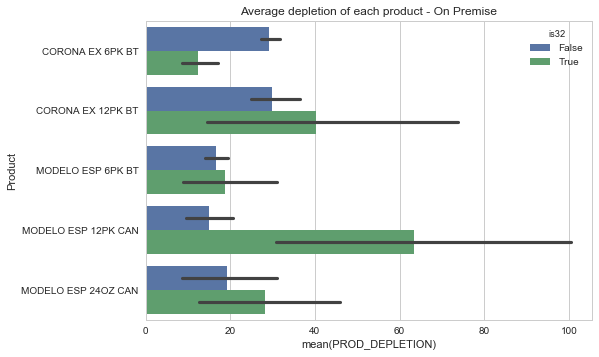

In [14]:
#plot Average depletion of each product for On-premise
plt.title("Average depletion of each product - On Premise")
sns.barplot(x='PROD_DEPLETION', y="Product", hue="is32", data=graph_DF);

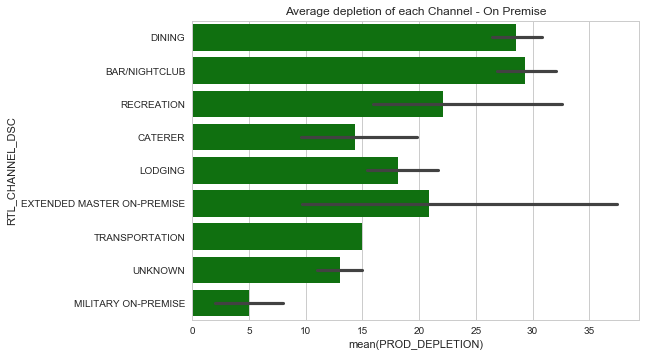

In [15]:
#plot Average depletion for each channel for On-premise
plt.title("Average depletion of each Channel - On Premise")
sns.barplot(x='PROD_DEPLETION', y="RTL_CHANNEL_DSC", data=graph_DF, color = 'Green');

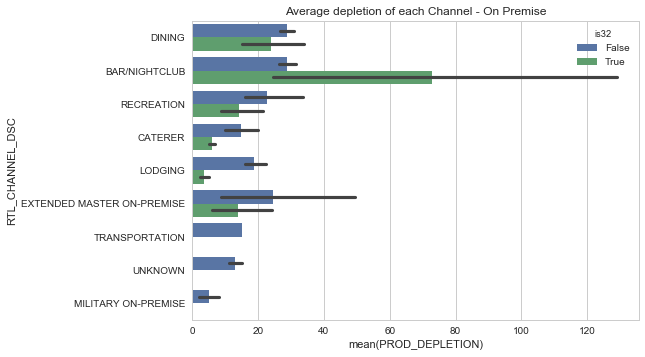

In [16]:
#plot Average depletion for each channel by beer type for On-premise
plt.title("Average depletion of each Channel - On Premise")
sns.barplot(x='PROD_DEPLETION', y="RTL_CHANNEL_DSC", hue = 'is32', data=graph_DF);

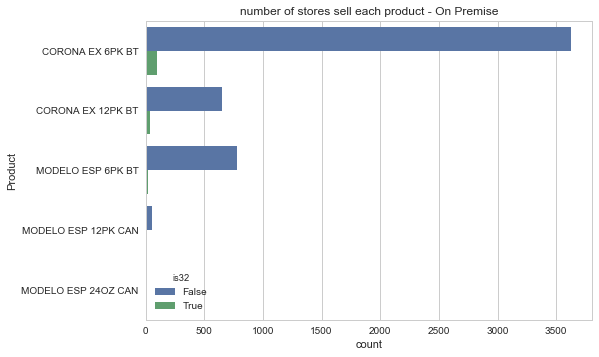

In [17]:
#plot number of stores sell each product for On-premise
plt.title("number of stores sell each product - On Premise")
graph = sns.countplot(y='Product', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['Product'].unique(), rotation=0);

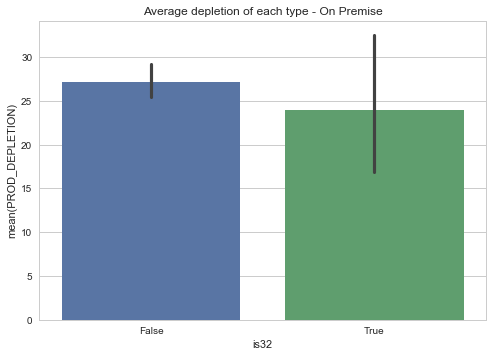

In [18]:
# Average depletion for 3.2 and Non 3.2 products
plt.title("Average depletion of each type - On Premise")
sns.barplot(x='is32', y = 'PROD_DEPLETION', data=graph_DF);

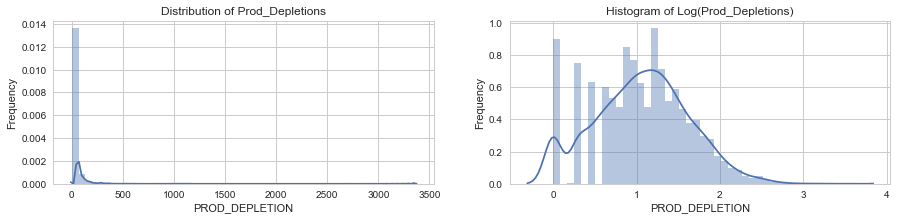

In [19]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title('Distribution of Prod_Depletions')
sns.distplot(Top5_On_pairs_stores['PROD_DEPLETION'])
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.title('Histogram of Log(Prod_Depletions)')
sns.distplot(np.log10(Top5_On_pairs_stores['PROD_DEPLETION'].values))
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency');

## Regression Analysis on Five products for On-premise

### Load Cluster data and Merge 

In [20]:
StoresON = pd.read_csv('MinnesotaONStores.csv', dtype = str)
del StoresON['Unnamed: 0']
StoresON['STORE_CD'] = StoresON['STORE_CD'].astype(str)
StoresON.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,...,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY,CLUSTER,RTL_STORE_CD,BEERTYPE
0,103793493,397.8332,DINING,CASUAL DINING,MEXICAN,True,True,0.7596,0.1108,0.0554,...,0.1052,0.0728,0.0595,0.0599,0.0413,0.0334,0.06899660038162903,0,103793493,NonLowPoint
1,105646503,13.0,BAR/NIGHTCLUB,CASUAL NIGHTCLUB,OTHER,True,True,0.9312,0.0072,0.0114,...,0.0546,0.0669,0.0703,0.0619,0.0402,0.0338,0.00215660240055082,0,105646503,NonLowPoint
2,105645328,6.0,DINING,CASUAL DINING,VARIED MENU,True,True,0.7775,0.0035,0.0019,...,0.0411,0.0345,0.053,0.0845,0.1039,0.0463,0.0009408029688293691,0,105645328,NonLowPoint
3,202252793,330.8054,DINING,CASUAL DINING,MEXICAN,True,True,0.953,0.0062,0.0091,...,0.0597,0.0594,0.0636,0.0676,0.053,0.0532,0.05735483450312345,0,202252793,NonLowPoint
4,105649082,28.0,LODGING,FULL SERVICE LODGING,OTHER,True,True,0.9072,0.0204,0.027000000000000003,...,0.0584,0.0588,0.0626,0.0695,0.0491,0.0463,0.0047618868970967865,0,105649082,NonLowPoint


In [21]:
#Inner join StoreON Data with Top5_On_pairs_stores for regression
RegressionDataON = pd.merge(StoresON, Top5_On_pairs_stores, left_on='STORE_CD', right_on="RTL_STORE_CD", how="inner")
RegressionDataON.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,...,RTL_STORE_CD_x,BEERTYPE,RTL_STORE_CD_y,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION,Product,is32
0,103793493,397.8332,DINING,CASUAL DINING,MEXICAN,True,True,0.7596,0.1108,0.0554,...,103793493,NonLowPoint,103793493,CORONA EX 12PK BT,DINING,CASUAL DINING,ON,94.0,CORONA EX 12PK BT,False
1,103793493,397.8332,DINING,CASUAL DINING,MEXICAN,True,True,0.7596,0.1108,0.0554,...,103793493,NonLowPoint,103793493,MODELO ESP 6PK BT,DINING,CASUAL DINING,ON,8.0,MODELO ESP 6PK BT,False
2,103793493,397.8332,DINING,CASUAL DINING,MEXICAN,True,True,0.7596,0.1108,0.0554,...,103793493,NonLowPoint,103793493,CORONA EX 6PK BT,DINING,CASUAL DINING,ON,53.0,CORONA EX 6PK BT,False
3,105646503,13.0,BAR/NIGHTCLUB,CASUAL NIGHTCLUB,OTHER,True,True,0.9312,0.0072,0.0114,...,105646503,NonLowPoint,105646503,CORONA EX 6PK BT,BAR/NIGHTCLUB,CASUAL NIGHTCLUB,ON,13.0,CORONA EX 6PK BT,False
4,105645328,6.0,DINING,CASUAL DINING,VARIED MENU,True,True,0.7775,0.0035,0.0019,...,105645328,NonLowPoint,105645328,CORONA EX 6PK BT,DINING,CASUAL DINING,ON,4.0,CORONA EX 6PK BT,False


In [22]:
len(RegressionDataON)

4280

In [23]:
#pair1: 
subset1 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[0, :]))].reset_index(drop=True)
Regression_ON_pair1_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset1)
print(Regression_ON_pair1_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.013
Model:                                OLS   Adj. R-squared:                  0.006
Method:                     Least Squares   F-statistic:                     1.765
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):              0.134
Time:                            16:05:21   Log-Likelihood:                -981.11
No. Observations:                     535   AIC:                             1972.
Df Residuals:                         530   BIC:                             1994.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

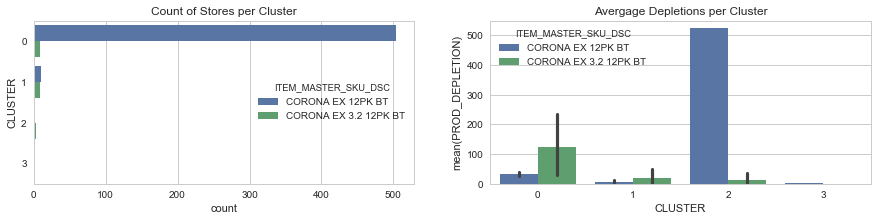

In [24]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset1);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset1);

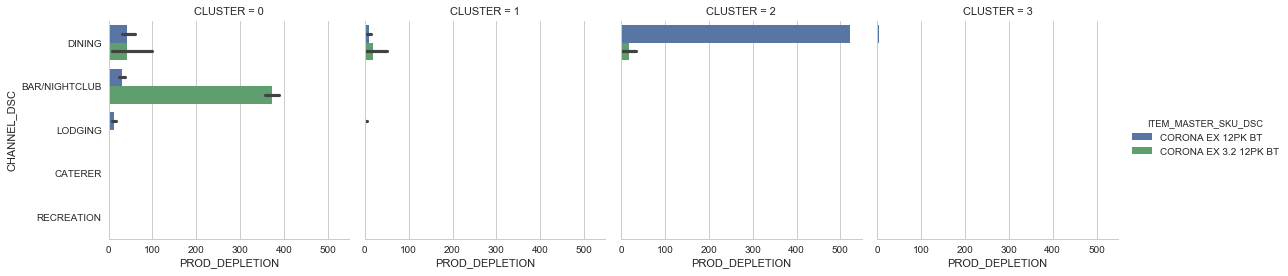

In [25]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset1, kind="bar");

In [26]:
#pair 2: 
subset2 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[1, :]))].reset_index(drop=True)
Regression_ON_pair2_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(CLUSTER)', data= subset2)
print(Regression_ON_pair2_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.030
Model:                                OLS   Adj. R-squared:                  0.029
Method:                     Least Squares   F-statistic:                     23.29
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           5.62e-19
Time:                            16:05:22   Log-Likelihood:                -4637.0
No. Observations:                    2971   AIC:                             9284.
Df Residuals:                        2966   BIC:                             9314.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

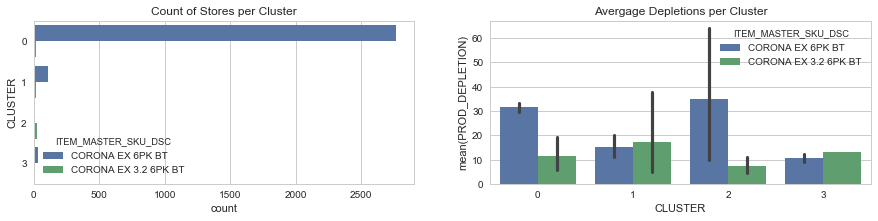

In [27]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset2);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset2);

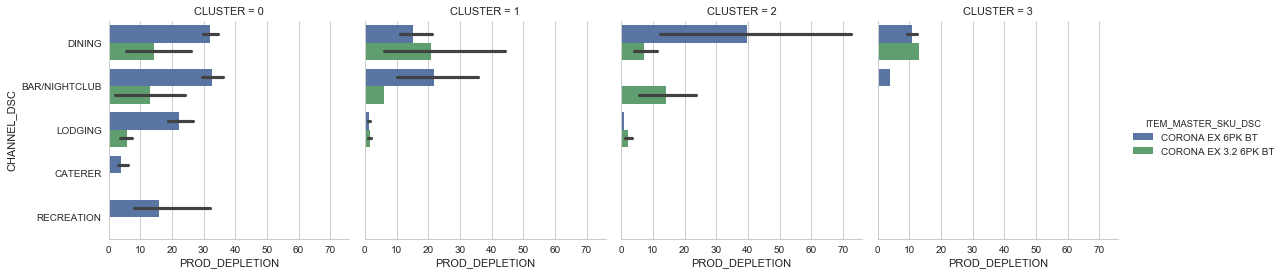

In [28]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset2, kind="bar");

In [29]:
#pair 3: 
subset3 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[2, :]))].reset_index(drop=True)
Regression_ON_pair3_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(CLUSTER)', data= subset3)
print(Regression_ON_pair3_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.270
Model:                                OLS   Adj. R-squared:                  0.221
Method:                     Least Squares   F-statistic:                     5.549
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):            0.00251
Time:                            16:05:24   Log-Likelihood:                -82.506
No. Observations:                      49   AIC:                             173.0
Df Residuals:                          45   BIC:                             180.6
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

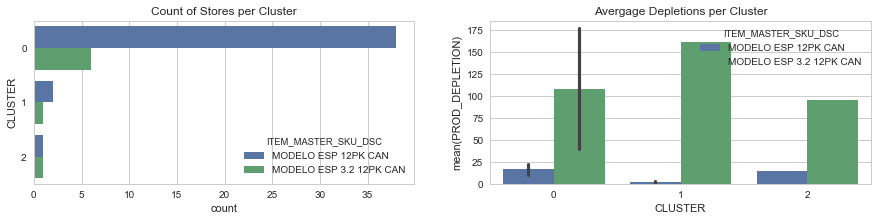

In [30]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset3);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset3);

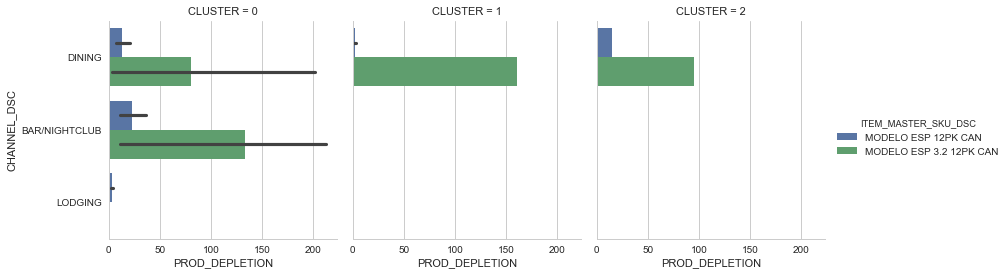

In [31]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset3, kind="bar");

In [32]:
#pair 4 
subset4 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[3, :]))].reset_index(drop=True)
Regression_ON_pair4_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(CLUSTER)', data= subset4)
print(Regression_ON_pair4_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.017
Model:                                OLS   Adj. R-squared:                  0.011
Method:                     Least Squares   F-statistic:                     2.982
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):             0.0186
Time:                            16:05:26   Log-Likelihood:                -1196.0
No. Observations:                     708   AIC:                             2402.
Df Residuals:                         703   BIC:                             2425.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

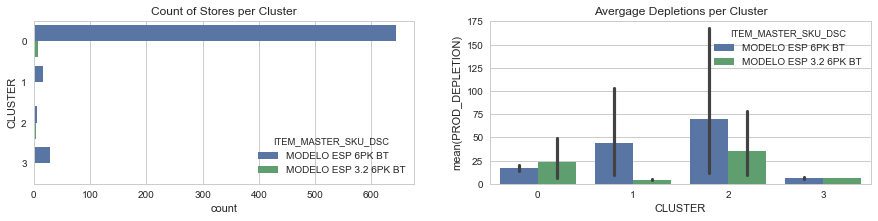

In [33]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset4);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset4);

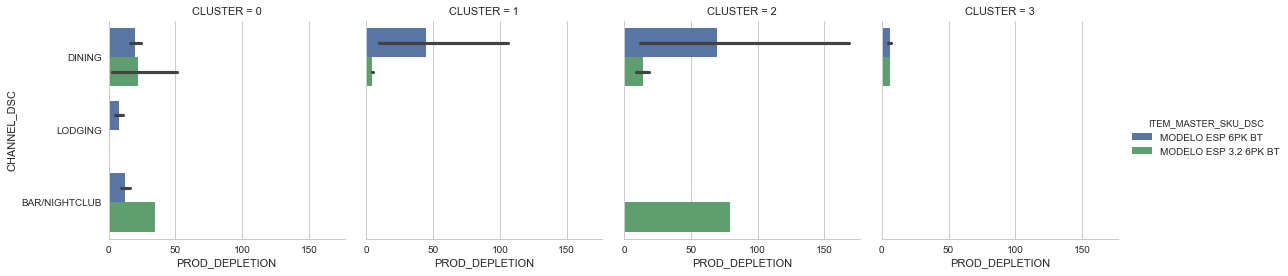

In [34]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset4, kind="bar");

In [35]:
#pair 5 
subset5 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[4, :]))].reset_index(drop=True)
Regression_ON_pair5_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(CLUSTER)', data= subset5)
print(Regression_ON_pair5_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.178
Model:                                OLS   Adj. R-squared:                  0.060
Method:                     Least Squares   F-statistic:                     1.512
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):              0.254
Time:                            16:05:28   Log-Likelihood:                -28.311
No. Observations:                      17   AIC:                             62.62
Df Residuals:                          14   BIC:                             65.12
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

C:\Users\qguo\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


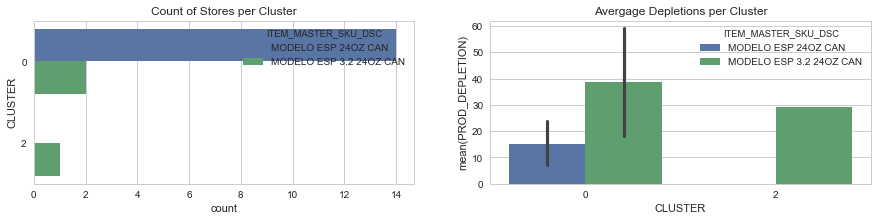

In [36]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset5);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset5);

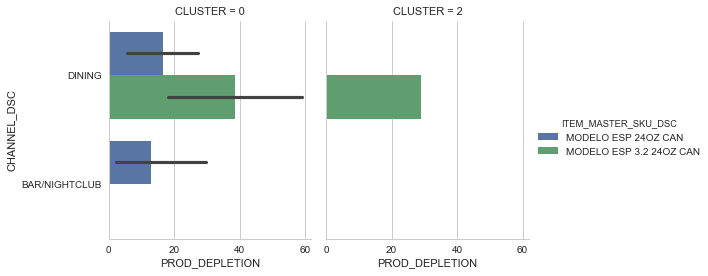

In [37]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset5, kind="bar");

## OFF PREMISE ANALYSIS

### Load Product Data for Off-Premise

In [38]:
#load the product data for Off Premise 
LowPointOff = LowPoint.loc[LowPoint['RTL_PREMISE_TYPE_CD'] == 'OFF', :].reset_index(drop = True)
Top5LowPointOff = LowPointOff.head(15)['ITEM_MASTER_SKU_DSC']
Top5LowPointOff

0           CORONA LT 12PK BT
1       CORONA EX 3.2 12PK BT
2            VICTORIA 12PK BT
3     MODELO ESP 3.2 12PK CAN
4           CORONA LT 24PK BT
5            CORONA LT 6PK BT
6        CORONA EX 3.2 6PK BT
7     MODELO CHELADA 24OZ CAN
8          CORONA LT 12PK CAN
9           CORONA LT 18PK BT
10            VICTORIA 6PK BT
11      MODELO ESP 3.2 6PK BT
12     MODELO ESP 3.2 12PK BT
13          VICTORIA 12PK CAN
14      CORONA EX 3.2 24OZ BT
Name: ITEM_MASTER_SKU_DSC, dtype: object

In [39]:
#select top 5 products that are comparable:
Top5LowPointOff = Top5LowPointOff[[1,3,6,11,12]]
#put the products and their pairs into datafame
Top5_LowPoint_Off_Pairs_DF = pd.DataFrame(Top5LowPointOff).reset_index(drop=True)
Top5_LowPoint_Off_Pairs_DF['PAIRS'] = ['CORONA EX 12PK BT', 'MODELO ESP 12PK CAN', 'CORONA EX 6PK BT', 'MODELO ESP 6PK BT', 'MODELO ESP 12PK BT']
Top5_LowPoint_Off_Pairs_DF

,ITEM_MASTER_SKU_DSC,PAIRS
0,CORONA EX 3.2 12PK BT,CORONA EX 12PK BT
1,MODELO ESP 3.2 12PK CAN,MODELO ESP 12PK CAN
2,CORONA EX 3.2 6PK BT,CORONA EX 6PK BT
3,MODELO ESP 3.2 6PK BT,MODELO ESP 6PK BT
4,MODELO ESP 3.2 12PK BT,MODELO ESP 12PK BT


In [40]:
BeerList_Off = list(Top5_LowPoint_Off_Pairs_DF['ITEM_MASTER_SKU_DSC']) + list(Top5_LowPoint_Off_Pairs_DF['PAIRS'])
BeerList_Off

['CORONA EX 3.2 12PK BT',
 'MODELO ESP 3.2 12PK CAN',
 'CORONA EX 3.2 6PK BT',
 'MODELO ESP 3.2 6PK BT',
 'MODELO ESP 3.2 12PK BT',
 'CORONA EX 12PK BT',
 'MODELO ESP 12PK CAN',
 'CORONA EX 6PK BT',
 'MODELO ESP 6PK BT',
 'MODELO ESP 12PK BT']

### Analysis for Off-Premise

In [41]:
#Subset Off-premise stores 
Top5_Off_pairs_stores = All_Stores_Minnesota.loc[All_Stores_Minnesota['RTL_PREMISE_TYPE_CD'] == 'OFF', :]

#Subset Off-premise stoers that sell top 5 pairs of beer (10 products)
Top5_Off_pairs_stores= Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(BeerList_Off)].reset_index(drop=True)

Top5_Off_pairs_stores.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,103923027,MODELO ESP 6PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,46.0
1,100187799,MODELO ESP 6PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,46.0
2,200763598,MODELO ESP 12PK CAN,LIQUOR,CONVENTIONAL LIQUOR,OFF,30.0
3,100702391,CORONA EX 3.2 12PK BT,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,OFF,13.0
4,101425627,CORONA EX 6PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,4.0


In [42]:
len(Top5_Off_pairs_stores)

6277

In [43]:
Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].unique()

array(['MODELO ESP 6PK BT', 'MODELO ESP 12PK CAN', 'CORONA EX 3.2 12PK BT',
       'CORONA EX 6PK BT', 'MODELO ESP 12PK BT', 'CORONA EX 12PK BT',
       'MODELO ESP 3.2 12PK CAN', 'CORONA EX 3.2 6PK BT',
       'MODELO ESP 3.2 6PK BT', 'MODELO ESP 3.2 12PK BT'], dtype=object)

In [44]:
#create a graph_DF for explanatory analysis.
graph_DF = Top5_Off_pairs_stores
graph_DF['Product'] = graph_DF['ITEM_MASTER_SKU_DSC']
for index in range(len(graph_DF['Product'])):
    if '3.2 ' in graph_DF.loc[index, 'Product']:
        graph_DF.loc[index, 'Product'] = graph_DF.loc[index, 'Product'].replace('3.2 ','')
graph_DF['is32'] = graph_DF['ITEM_MASTER_SKU_DSC'] != graph_DF['Product']  

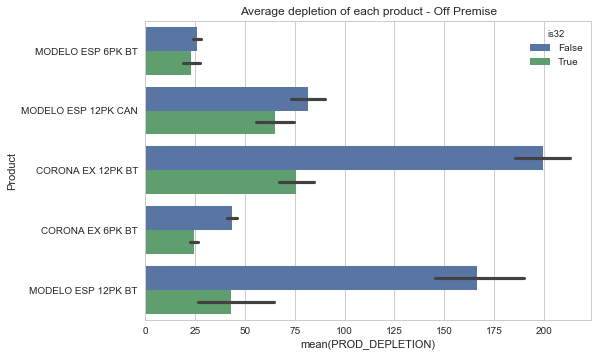

In [45]:
#plot Average depletion of each product for Off-premise
plt.title("Average depletion of each product - Off Premise")
sns.barplot(x='PROD_DEPLETION', y="Product", hue="is32", data=graph_DF);

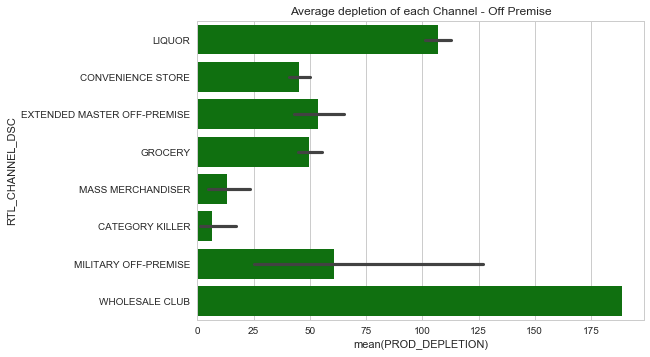

In [46]:
#plot Average depletion for each channel for Off-premise
plt.title("Average depletion of each Channel - Off Premise")
sns.barplot(x='PROD_DEPLETION', y="RTL_CHANNEL_DSC", data=graph_DF, color = 'Green');

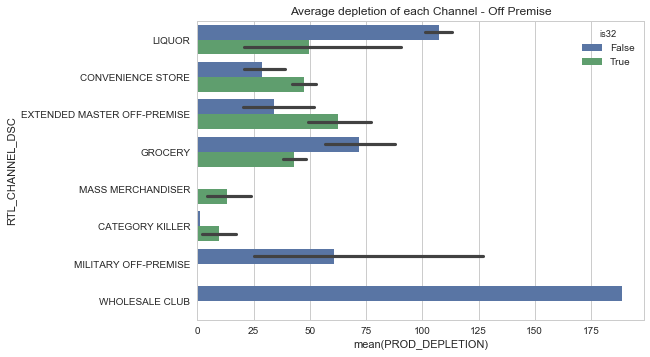

In [47]:
#plot Average depletion for each channel by beer type for Off-premise
plt.title("Average depletion of each Channel - Off Premise")
sns.barplot(x='PROD_DEPLETION', y="RTL_CHANNEL_DSC", hue = 'is32', data=graph_DF);

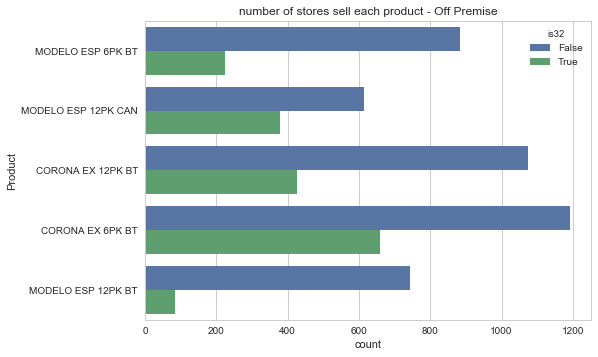

In [48]:
#plot number of stores sell each product for Off-premise
plt.title("number of stores sell each product - Off Premise")
graph = sns.countplot(y='Product', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['Product'].unique(), rotation=0);

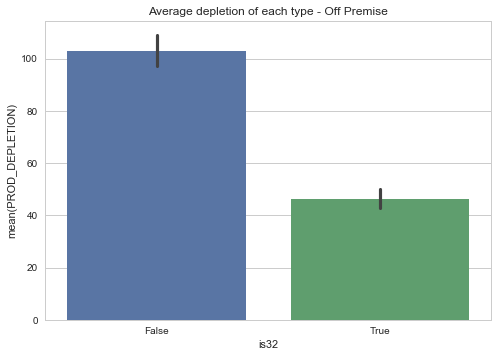

In [49]:
# Average depletion for 3.2 and Non 3.2 products
plt.title("Average depletion of each type - Off Premise")
sns.barplot(x='is32', y = 'PROD_DEPLETION', data=graph_DF);

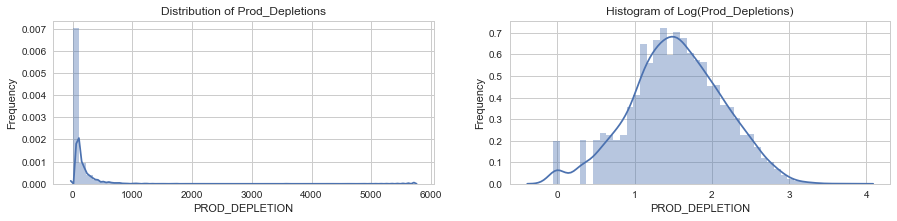

In [50]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title('Distribution of Prod_Depletions')
sns.distplot(Top5_Off_pairs_stores['PROD_DEPLETION'])
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.title('Histogram of Log(Prod_Depletions)')
sns.distplot(np.log10(Top5_Off_pairs_stores['PROD_DEPLETION'].values))
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency');

### Regression Analysis on Five products for Off-premise

### Load clustering data and Merge 

In [51]:
StoresOFF = pd.read_csv('MinnesotaOFFStores.csv')
del StoresOFF['Unnamed: 0']
StoresOFF['STORE_CD'] = StoresOFF['STORE_CD'].astype(str)
StoresOFF.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,...,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,NORM_L12M_TY_QTY,CLUSTER,RTL_STORE_CD,BEERTYPE
0,101762688,849.9996,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9268,0.0038,0.0168,0.0441,...,0.0568,0.0611,0.0642,0.0635,0.0399,0.0336,0.019863,0,101762688.0,NonLowPoint
1,100413001,90.0000,GROCERY,SUPERMARKET-CONVENTIONAL,False,False,0.8122,0.0801,0.0579,0.0300,...,0.0831,0.0677,0.0641,0.0732,0.0530,0.0454,0.002082,1,NaN,LowPoint
2,100570775,27.0000,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,False,False,0.8396,0.0601,0.0472,0.0355,...,0.0656,0.0751,0.0709,0.0733,0.0507,0.0475,0.000608,1,NaN,LowPoint
3,100765405,250.5000,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9007,0.0271,0.0278,0.0300,...,0.0806,0.0568,0.0474,0.0551,0.0388,0.0375,0.005837,0,100765405.0,NonLowPoint
4,102912880,52.2500,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.8278,0.0322,0.0889,0.0371,...,0.0758,0.0663,0.0647,0.0698,0.0472,0.0434,0.001199,0,102912880.0,NonLowPoint


In [52]:
#Inner join StoreON Data with Top5_On_pairs_stores for regression
RegressionDataOFF = pd.merge(StoresOFF, Top5_Off_pairs_stores, left_on='STORE_CD', right_on="RTL_STORE_CD", how="inner")
RegressionDataOFF.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,...,RTL_STORE_CD_x,BEERTYPE,RTL_STORE_CD_y,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION,Product,is32
0,101762688,849.9996,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9268,0.0038,0.0168,0.0441,...,101762688.0,NonLowPoint,101762688,CORONA EX 12PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,164.0,CORONA EX 12PK BT,False
1,101762688,849.9996,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9268,0.0038,0.0168,0.0441,...,101762688.0,NonLowPoint,101762688,CORONA EX 6PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,51.0,CORONA EX 6PK BT,False
2,101762688,849.9996,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9268,0.0038,0.0168,0.0441,...,101762688.0,NonLowPoint,101762688,MODELO ESP 12PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,126.0,MODELO ESP 12PK BT,False
3,101762688,849.9996,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9268,0.0038,0.0168,0.0441,...,101762688.0,NonLowPoint,101762688,MODELO ESP 12PK CAN,LIQUOR,CONVENTIONAL LIQUOR,OFF,83.0,MODELO ESP 12PK CAN,False
4,101762688,849.9996,LIQUOR,CONVENTIONAL LIQUOR,True,True,0.9268,0.0038,0.0168,0.0441,...,101762688.0,NonLowPoint,101762688,MODELO ESP 6PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,21.0,MODELO ESP 6PK BT,False


In [53]:
len(RegressionDataOFF)

5938

### Regression controlling for Cluster

In [54]:
#pair1: 
subset1 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[0, :]))].reset_index(drop=True)
Regression_Off_pair1_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset1)
print(Regression_Off_pair1_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.162
Model:                                OLS   Adj. R-squared:                  0.161
Method:                     Least Squares   F-statistic:                     137.5
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           2.61e-55
Time:                            16:05:34   Log-Likelihood:                -2233.6
No. Observations:                    1421   AIC:                             4473.
Df Residuals:                        1418   BIC:                             4489.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

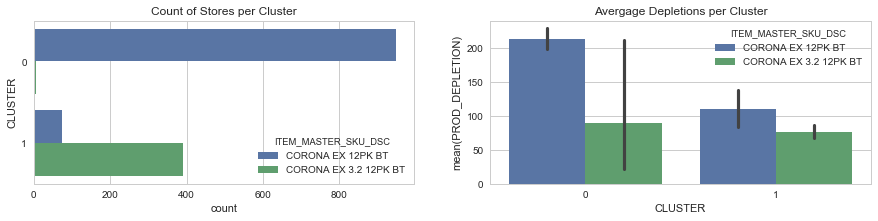

In [55]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset1);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset1);

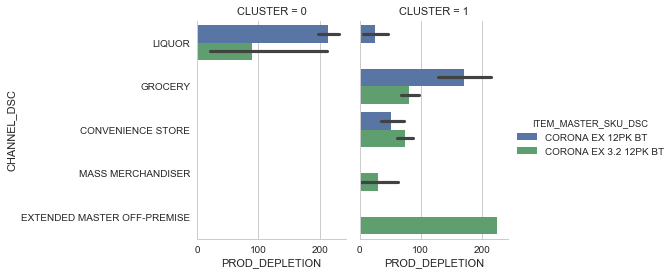

In [56]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset1, kind="bar");

In [57]:
#pair2:
subset2 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[1, :]))].reset_index(drop=True)
Regression_Off_pair2_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset2)
print(Regression_Off_pair2_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.037
Model:                                OLS   Adj. R-squared:                  0.035
Method:                     Least Squares   F-statistic:                     17.91
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           2.33e-08
Time:                            16:05:36   Log-Likelihood:                -1572.2
No. Observations:                     942   AIC:                             3150.
Df Residuals:                         939   BIC:                             3165.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

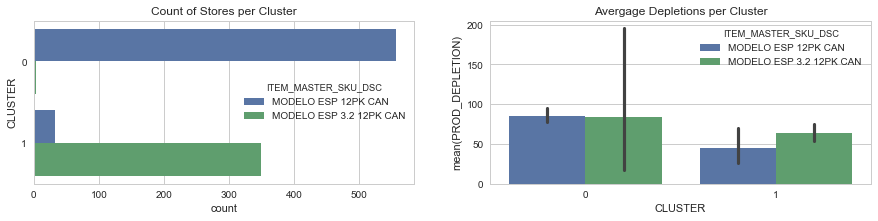

In [58]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset2);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset2);

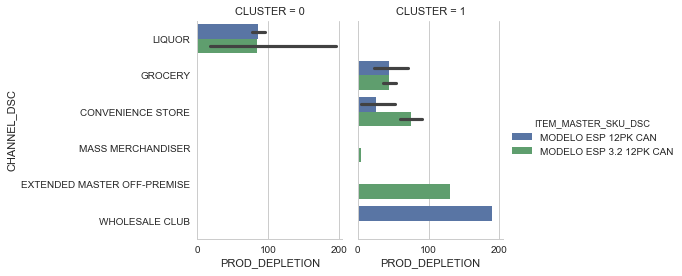

In [59]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset2, kind="bar");

In [60]:
#pair3: 
subset3 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[2, :]))].reset_index(drop=True)
Regression_Off_pair3_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset3)
print(Regression_Off_pair3_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.097
Model:                                OLS   Adj. R-squared:                  0.096
Method:                     Least Squares   F-statistic:                     93.59
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           2.47e-39
Time:                            16:05:37   Log-Likelihood:                -2456.4
No. Observations:                    1745   AIC:                             4919.
Df Residuals:                        1742   BIC:                             4935.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

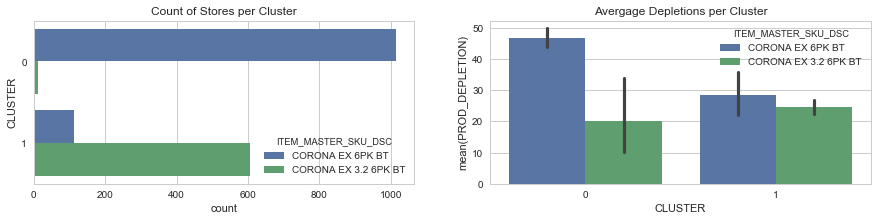

In [61]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset3);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset3);

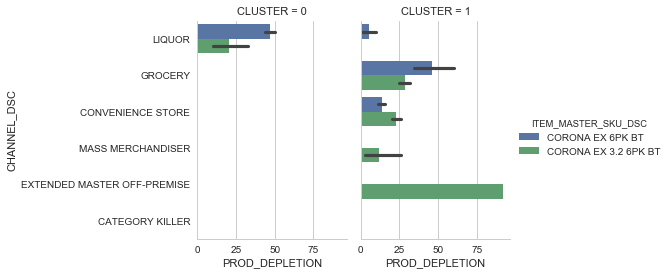

In [62]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset3, kind="bar");

In [63]:
#pair4: 
subset4 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[3, :]))].reset_index(drop=True)
Regression_Off_pair4_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset4)
print(Regression_Off_pair4_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.037
Model:                                OLS   Adj. R-squared:                  0.035
Method:                     Least Squares   F-statistic:                     19.73
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           3.90e-09
Time:                            16:05:38   Log-Likelihood:                -1546.1
No. Observations:                    1044   AIC:                             3098.
Df Residuals:                        1041   BIC:                             3113.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

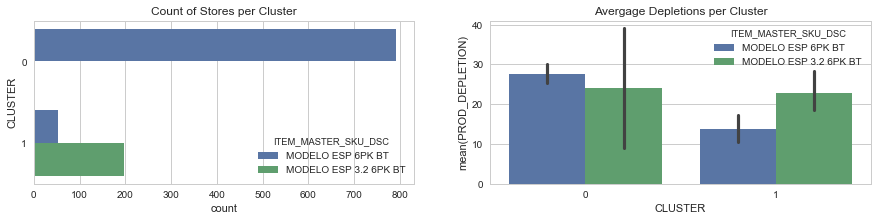

In [64]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset4);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset4);

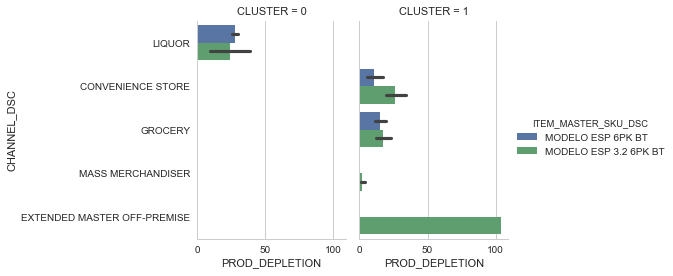

In [65]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset4, kind="bar");

In [66]:
#pair5: 
subset5 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[4, :]))].reset_index(drop=True)
Regression_Off_pair5_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset5)
print(Regression_Off_pair5_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.146
Model:                                OLS   Adj. R-squared:                  0.144
Method:                     Least Squares   F-statistic:                     67.10
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           1.27e-27
Time:                            16:05:40   Log-Likelihood:                -1369.2
No. Observations:                     786   AIC:                             2744.
Df Residuals:                         783   BIC:                             2758.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

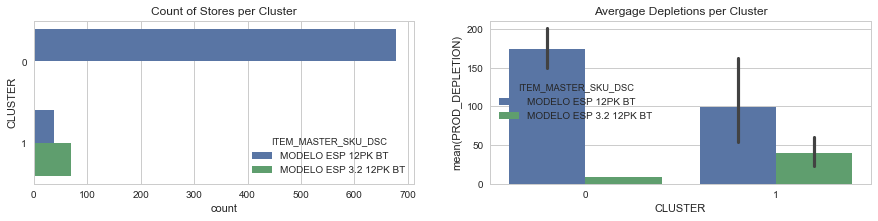

In [67]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset5);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset5);

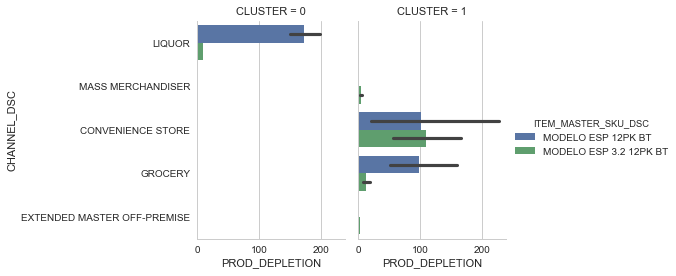

In [68]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset5, kind="bar");